## 📊 W&B Data Extraction, Processing, and Excel Export 📂

#### This notebook contains code to:
- Retrieve data from **Weights & Biases** using the API
- Perform minimal processing on the data to obtain best metric values and metric values at the epoch where a certain metric is maximized (e.g. Mean Dice)
- Export the processed data to **Excel** for further analysis


---

#### 🔬 This cell is where you specify the experiments that you would like to analyze

In [1]:
import wandb

api = wandb.Api()

entity = 'brats_dann'   # Keep the same
project = 'Debugging loss codes'  # Your project name
experiment_name = 'isbi24'  # text segment to identify experiment

runs = api.runs(path=f'{entity}/{project}')

run_ids_dict = {}
for i in runs:
    if experiment_name in i.name:
        print("run name = ",i.name," id: ", i.id)
        fold_no = i.name.split('-test')[0].split('-')[-1]
        run_ids_dict[fold_no] = i.id
run_ids_dict

run name =  UNet-fold1-test3_boxloss_isbi24  id:  kqgjghul
run name =  UNet-fold2-test3_boxloss_isbi24  id:  rmugedvf
run name =  UNet-fold0-test3_boxloss_isbi24  id:  reupo79e
run name =  UNet-fold4-test3_boxloss_isbi24  id:  f5hu42jk
run name =  UNet-fold3-test3_boxloss_isbi24  id:  jra6we3x


{'fold1': 'kqgjghul',
 'fold2': 'rmugedvf',
 'fold0': 'reupo79e',
 'fold4': 'f5hu42jk',
 'fold3': 'jra6we3x'}

#### 📈 This cell contains a function that allows you to plot metrics of interest. At the bottom of the cell, a dictionary containing the metrics of interest is defined.

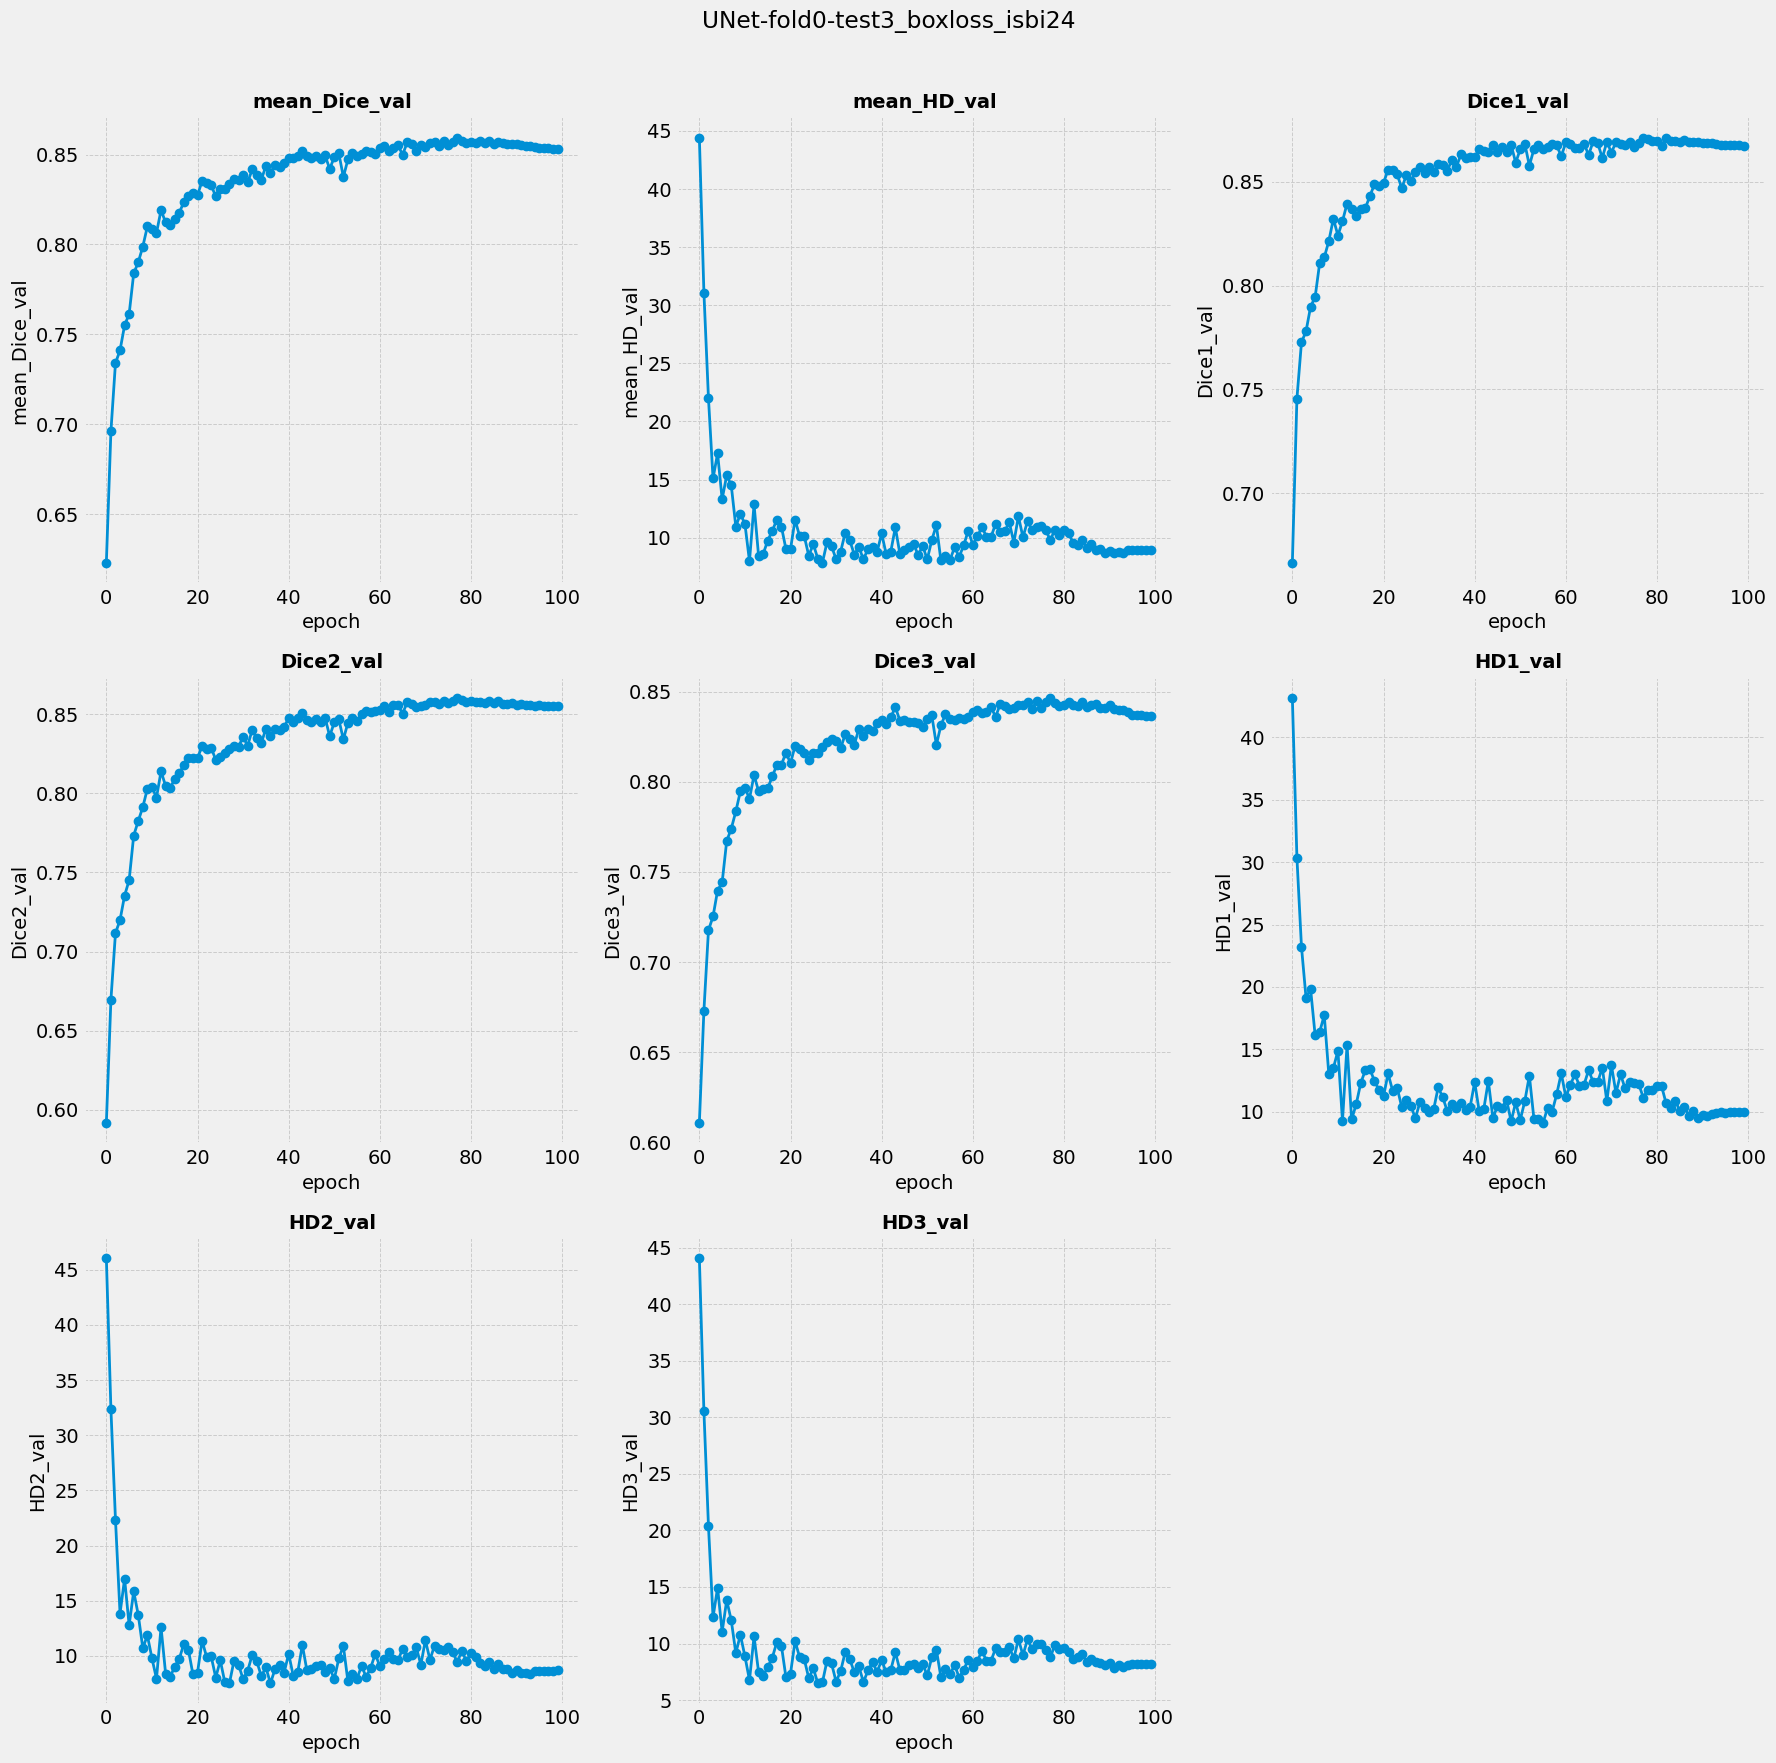

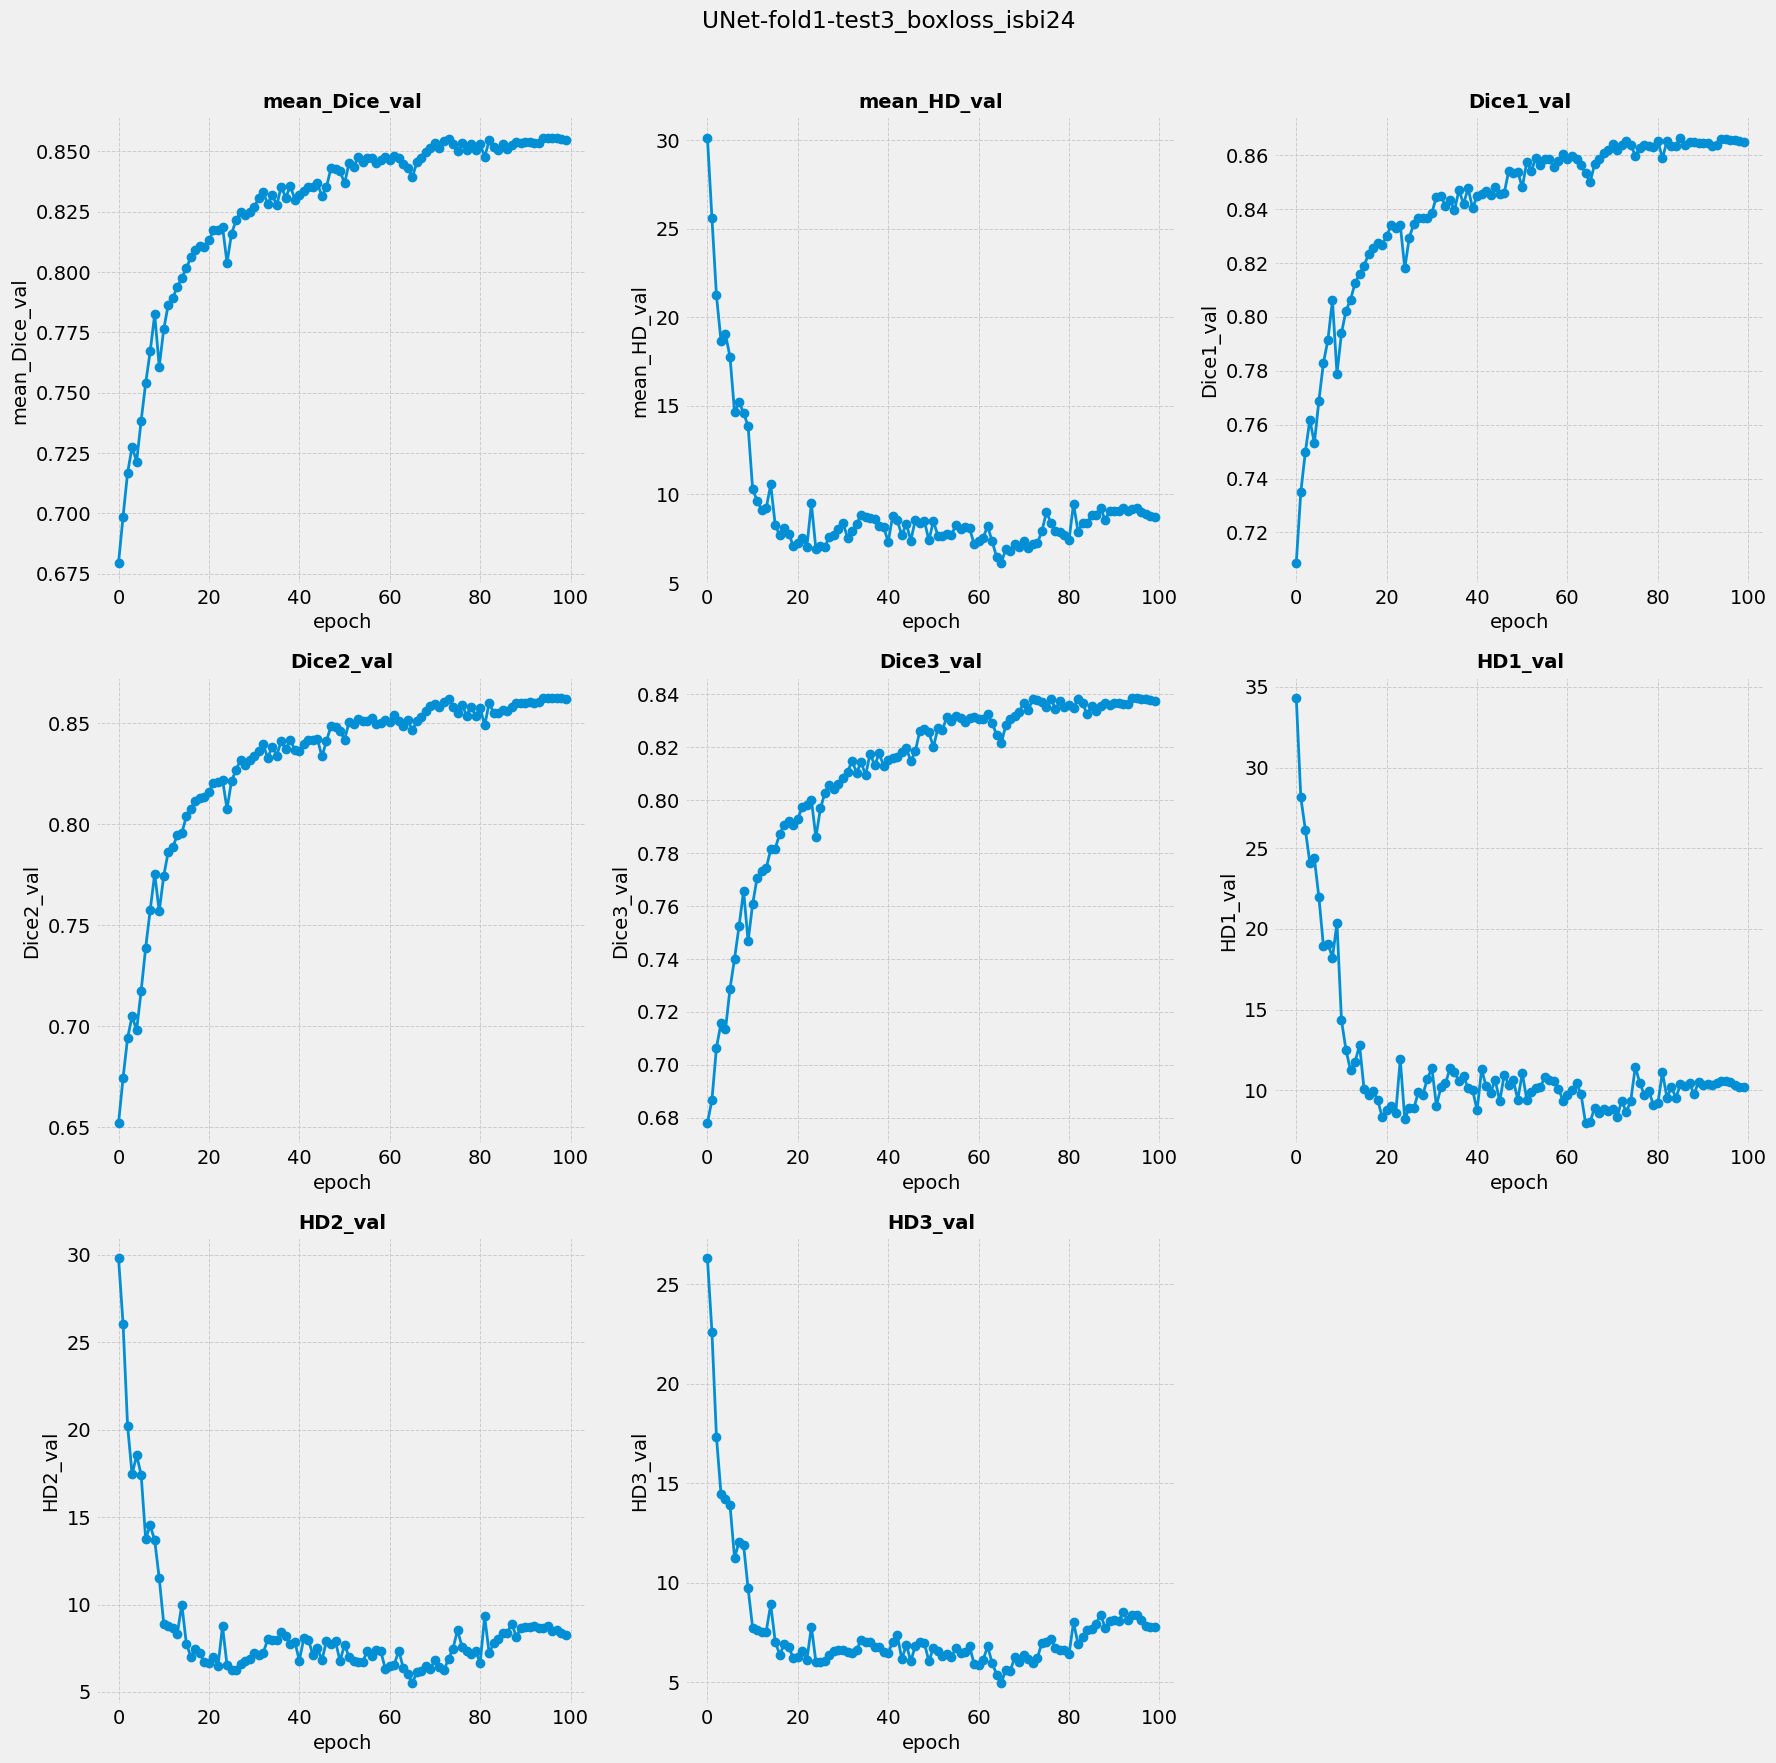

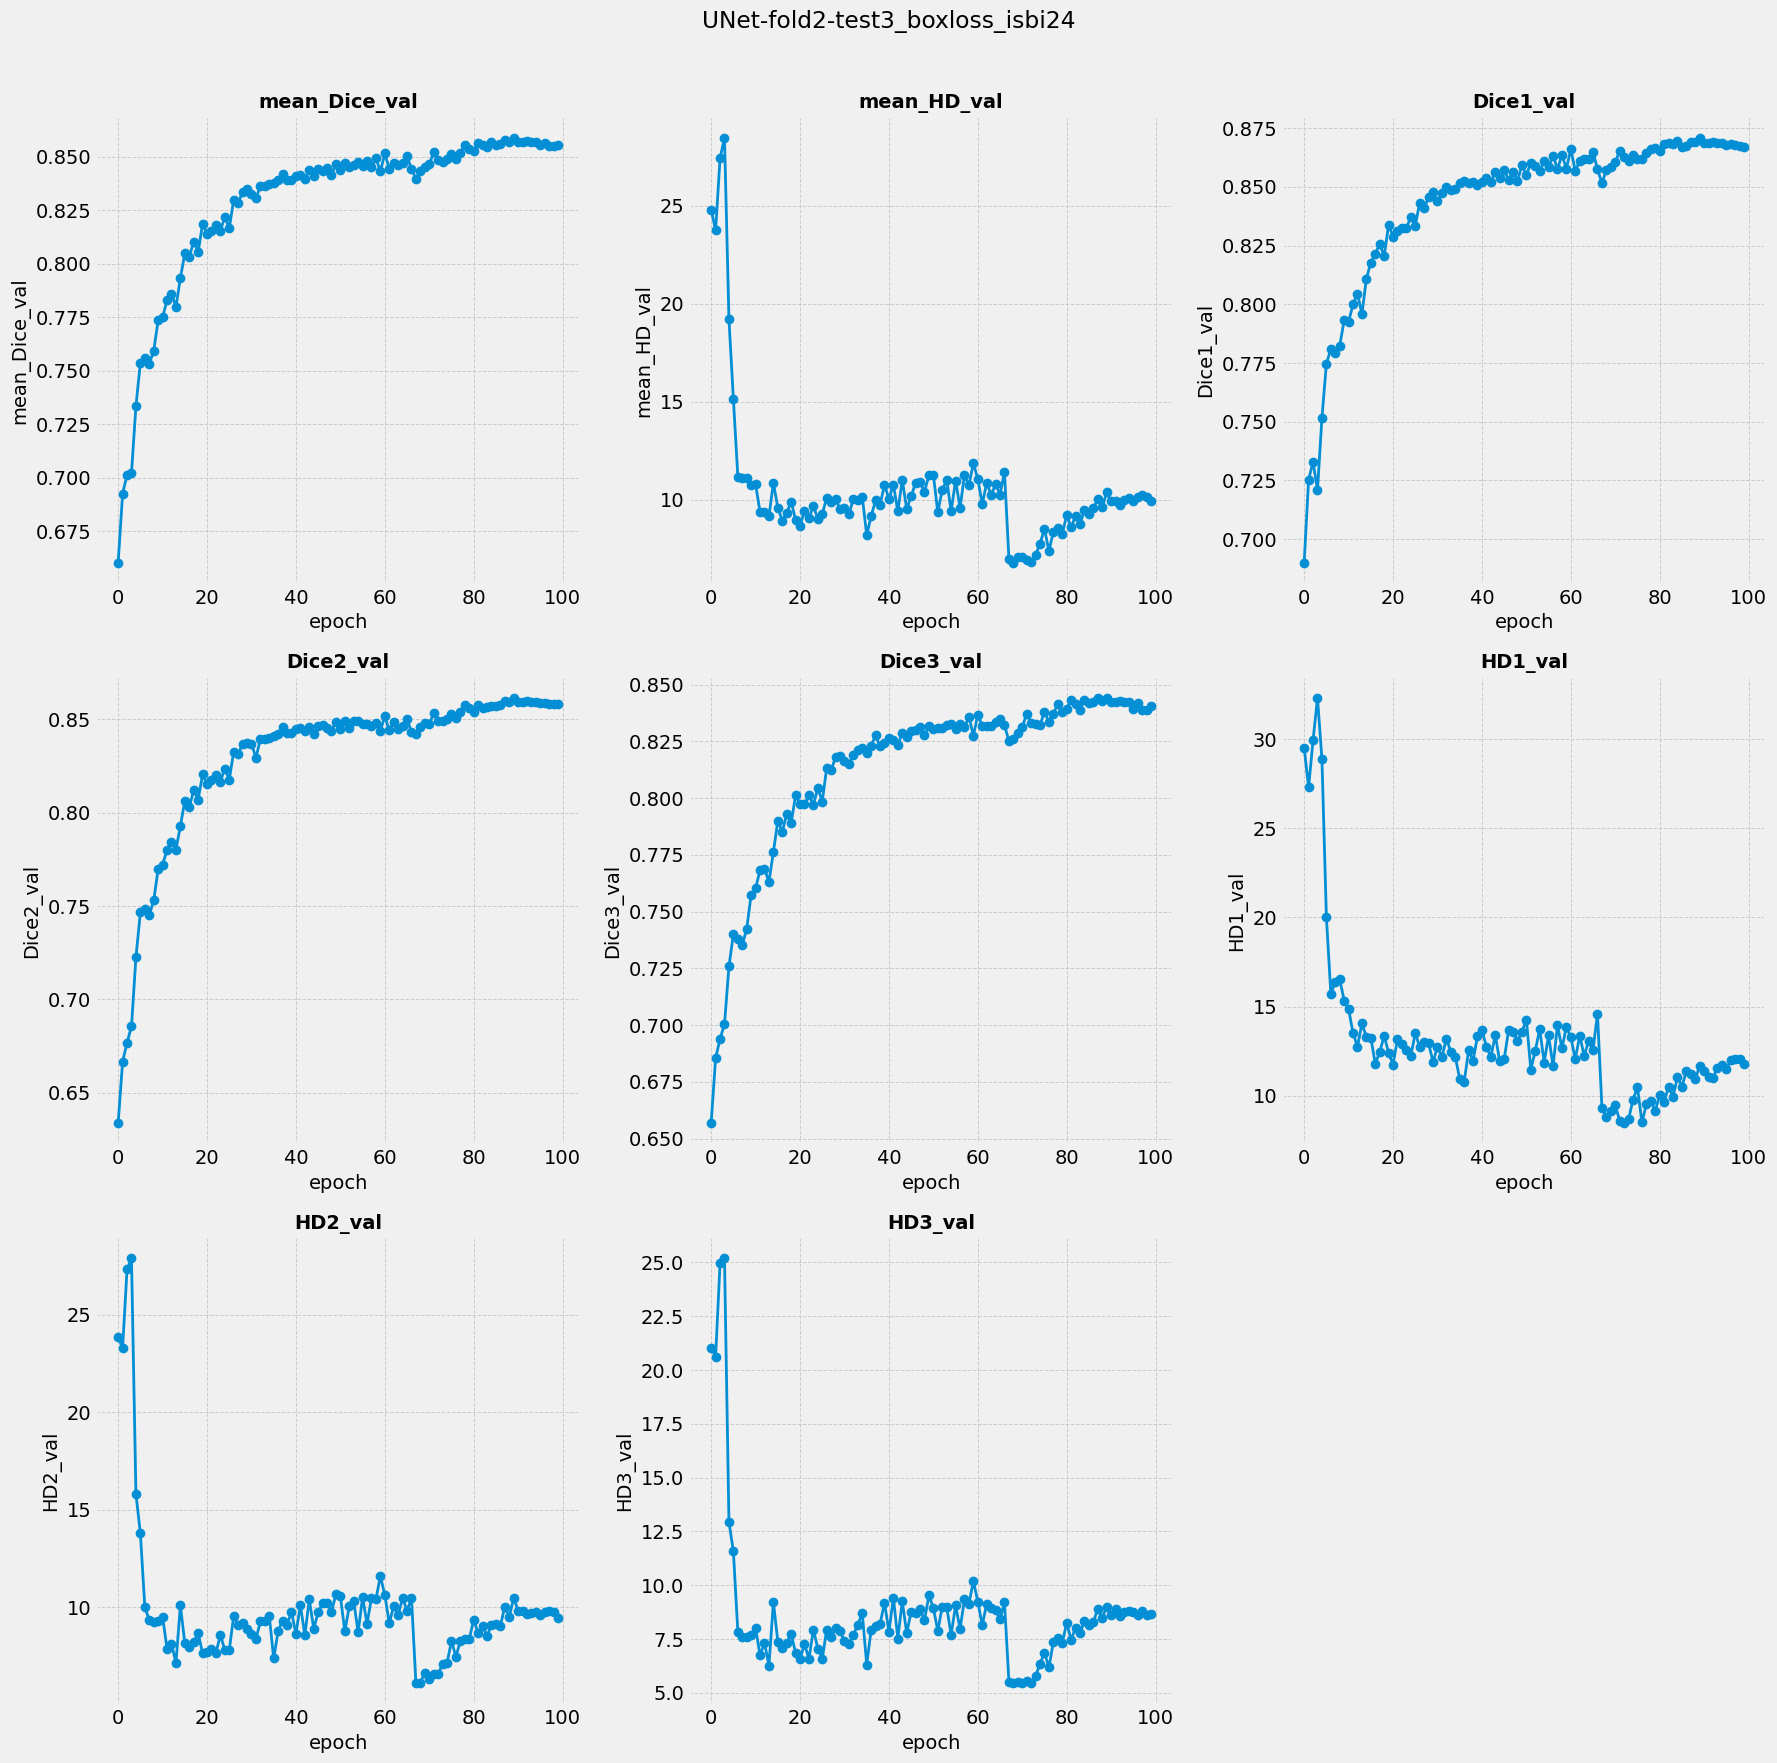

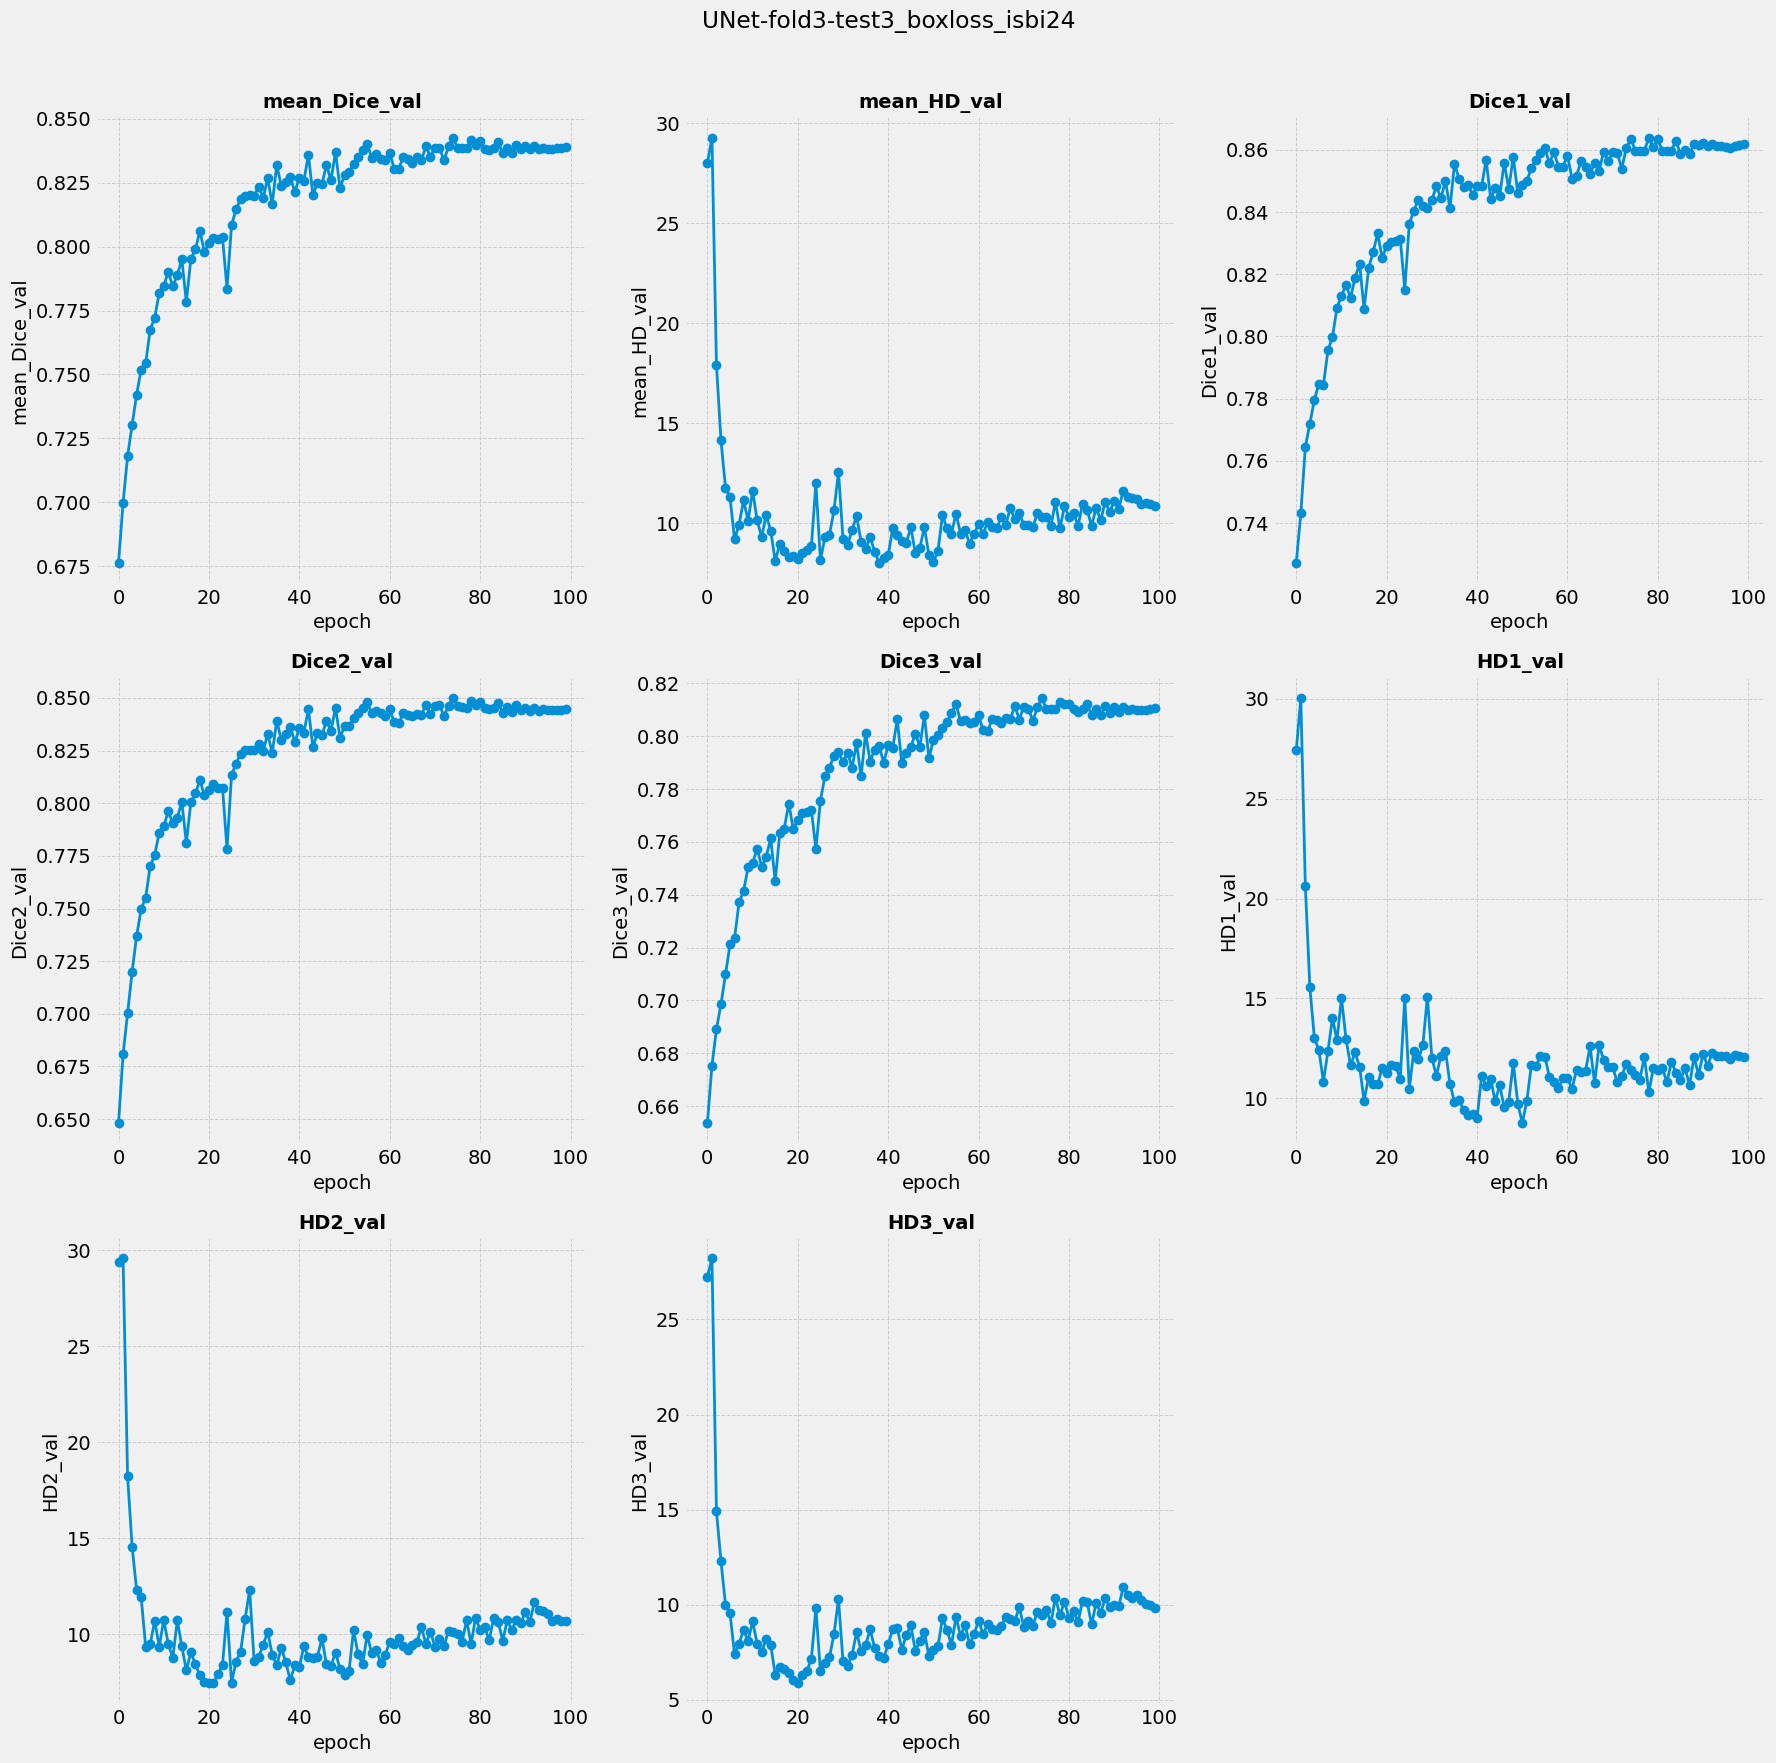

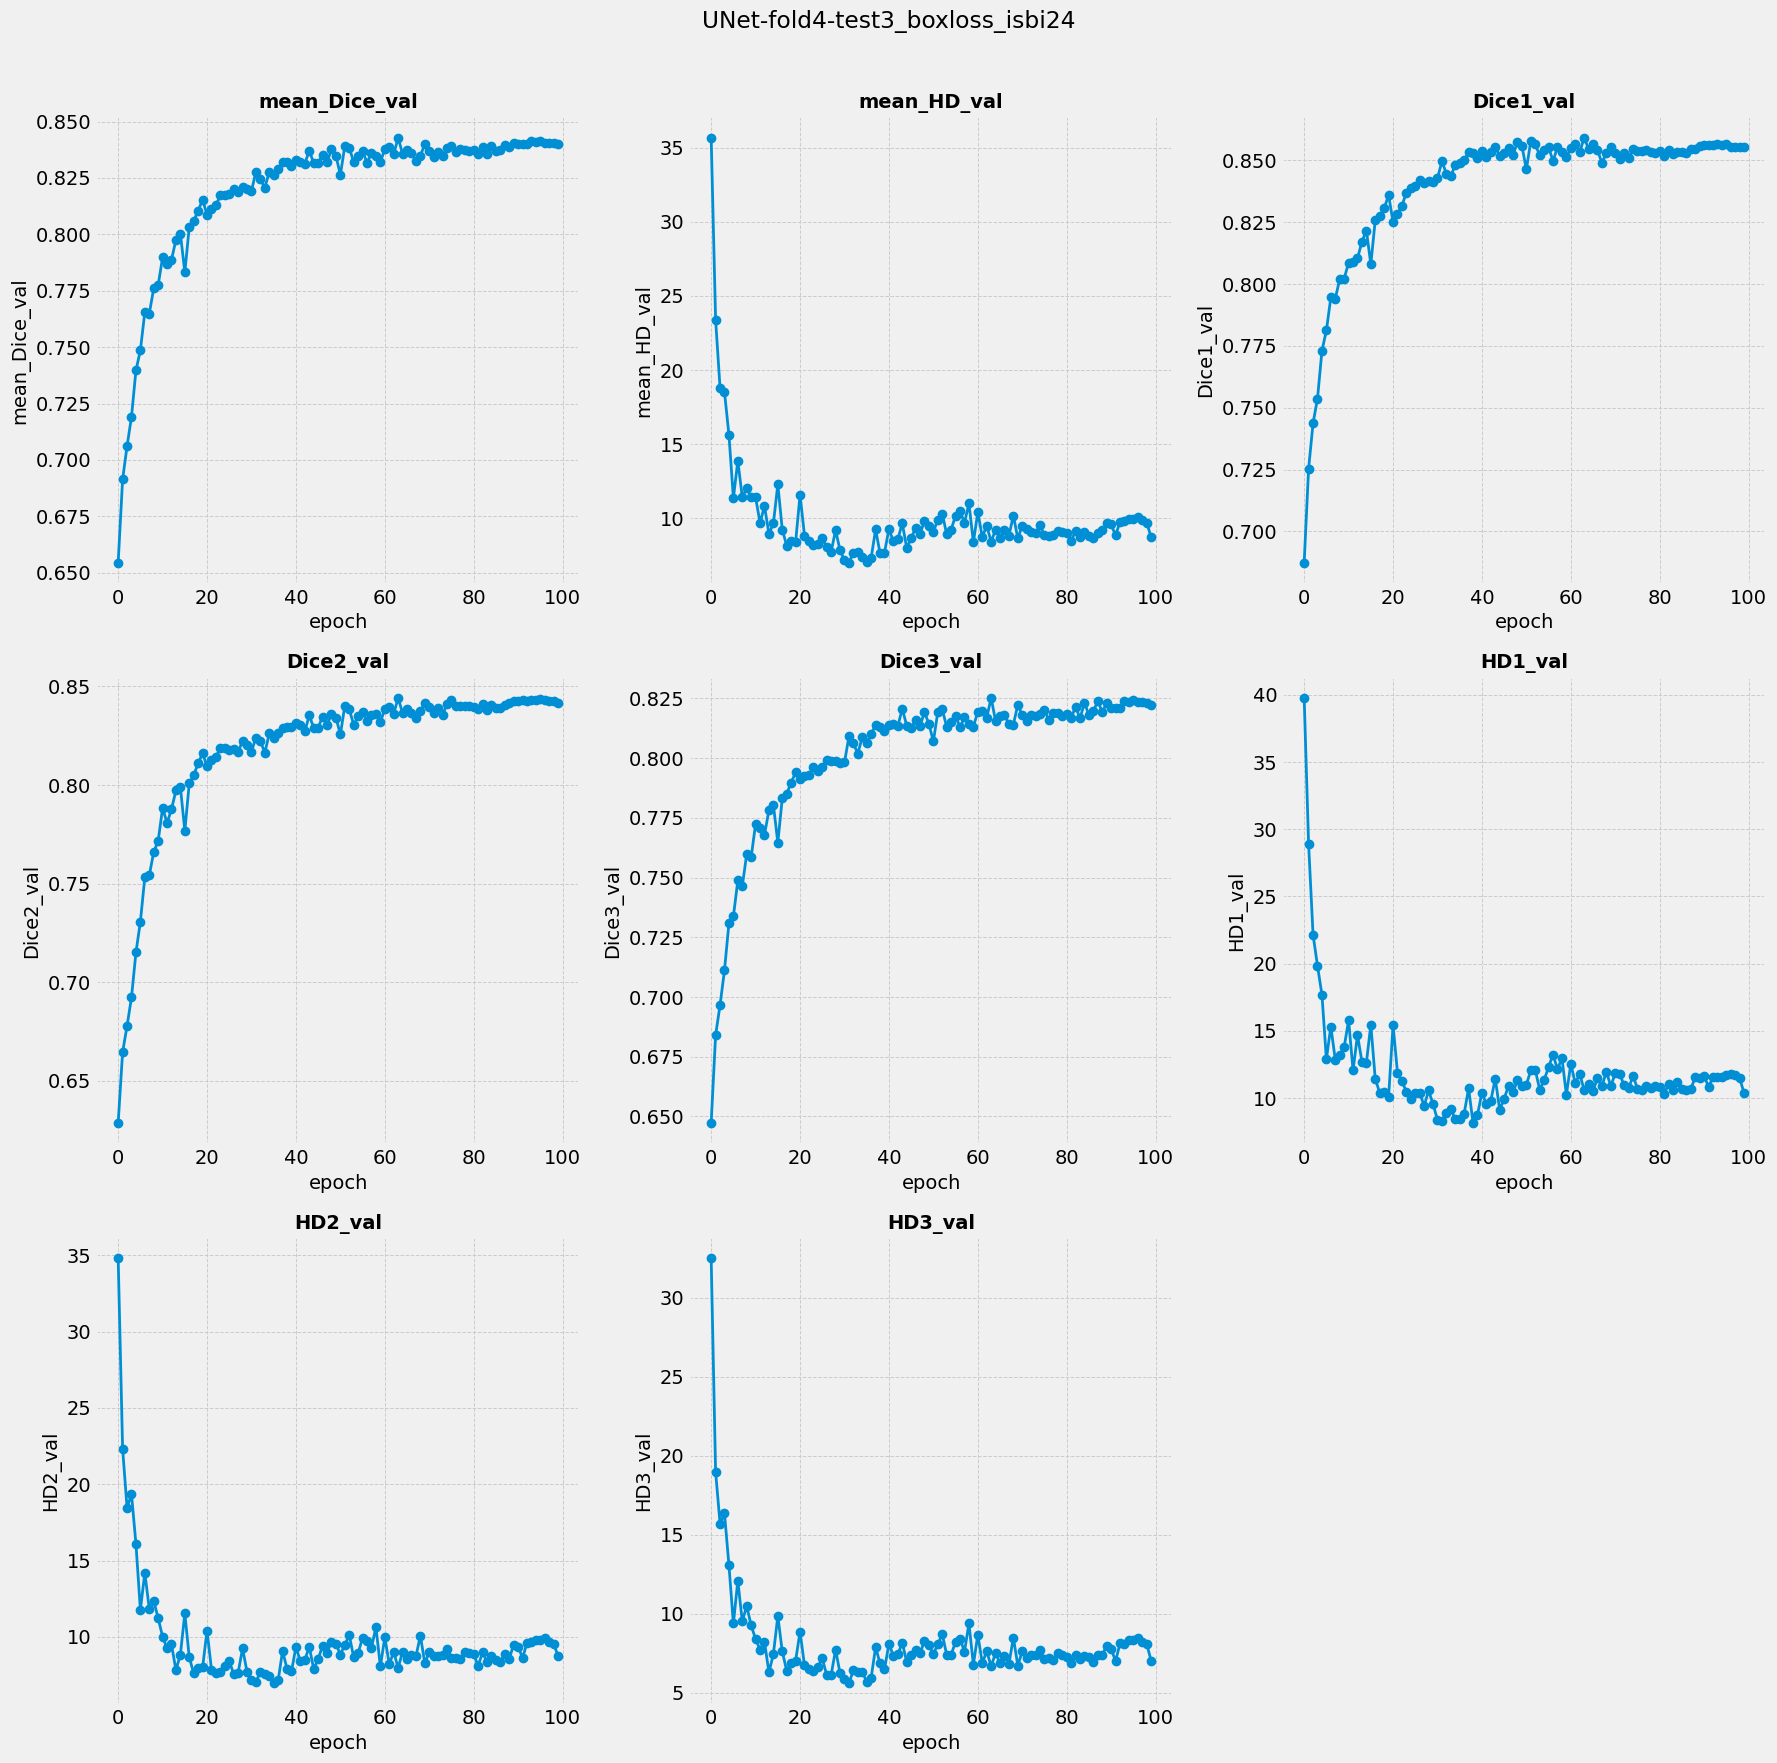

In [3]:
import wandb
import matplotlib.pyplot as plt
import math

def plot_wandb_metrics(entity, project, run_id, horizontal_axis, vertical_axes, show_plots = True):
    """
    Fetch data from Weights and Biases (W&B) and plot multiple vertical axes against a common horizontal axis.
    Plots are arranged in rows of 3 columns.

    Parameters:
    entity (str): W&B entity (username or team).
    project (str): W&B project name.
    run_id (str): W&B run ID.
    horizontal_axis (str): Column to use for the horizontal axis.
    vertical_axes (list): List of columns to use for the vertical axes.
    show_plots (bool): Whether to show plots

    Returns:
    results_dict (dict): Dictionary where each key is a vertical axis and the value is the DataFrame of the queried data for that axis.
    """
    # Initialize the W&B API
    api = wandb.Api()

    run = api.run(f"{entity}/{project}/{run_id}")

    history = run.history(samples=100000)  # Adjust the sample size if needed

    columns_to_query = [horizontal_axis] + vertical_axes
    available_columns = [col for col in columns_to_query if col in history.columns]

    if not available_columns:
        print(f"None of the specified columns were found in the run history: {columns_to_query}")
        return None
    
    # Query the data for the requested columns
    queried_data = history[available_columns]

    # Consolidate data by grouping by the horizontal axis and dropping NaN values
    consolidated_data = queried_data.groupby(horizontal_axis).agg(
        lambda x: x.dropna().iloc[0] if not x.dropna().empty else None
    ).reset_index()
    queried_data = consolidated_data.dropna(how='all', subset=available_columns[1:])

    # Dictionary to hold data for each vertical axis
    results_dict = {}
    for vertical_axis in vertical_axes:
        results_dict[vertical_axis] = queried_data[[horizontal_axis, vertical_axis]].dropna()

    # Set plot style
    plt.style.use('fivethirtyeight')

    # Determine the number of rows and columns for subplots (max 3 columns per row)
    num_plots = len(vertical_axes)
    num_cols = min(3, num_plots)  # Max 3 columns
    num_rows = math.ceil(num_plots / 3)  # Calculate the required number of rows

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))

    # Handle cases where we have a single row of subplots
    if num_plots == 1:
        axes = [axes]  # Single plot, make it iterable
    elif num_rows == 1:
        axes = axes.flatten()  # Flatten if only one row of subplots
    else:
        axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Plot each vertical axis in its corresponding subplot
    for i, vertical_axis in enumerate(vertical_axes):
        axes[i].plot(results_dict[vertical_axis][horizontal_axis], results_dict[vertical_axis][vertical_axis], marker='o', linestyle='-', linewidth=2)
        axes[i].set_ylabel(vertical_axis, fontsize=14)
        axes[i].set_xlabel(horizontal_axis, fontsize=14)
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)
        axes[i].set_title(vertical_axis, fontsize=14, fontweight='bold')

    # Hide any unused subplots (if the number of plots is less than the grid size)
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[i])

    # Display the plot
    plt.suptitle(run.name)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    if not show_plots:
        plt.close()

    # Return the dictionary containing the queried data
    return results_dict


# Example usage
metrics_dicts = {}
for fold_no in range(5):
    entity = 'brats_dann'
    project = 'Debugging loss codes'
    # project ='BraTS Goat 5-fold Test'
    fold_name = f'fold{fold_no}'
    run_id = run_ids_dict[fold_name]
    horizontal_axis = 'epoch'
    vertical_axes = ['mean_Dice_val', 'mean_HD_val', 'Dice1_val', 'Dice2_val', 'Dice3_val', 'HD1_val', 'HD2_val', 'HD3_val'] 
    metrics_dicts[fold_name] = plot_wandb_metrics(entity, project, run_id, horizontal_axis, vertical_axes, show_plots = True)

#### This next cell will find the epoch where the metric **'max_metric_for_epoch'** is maximized, and write the value of the remaining metrics to an Excel.

In [15]:
import pandas as pd

epoch_cutoff = 100
max_metric_for_epoch = 'mean_Dice_val'

data_for_excel = []
# Loop through each fold key in the metrics dictionary
for key in metrics_dicts.keys():
    metrics_dfs = metrics_dicts[key]
    
    # Check if max_metric_for_epoch is present in the DataFrame dictionary
    if max_metric_for_epoch in metrics_dfs:
        df_dice = metrics_dfs[max_metric_for_epoch][metrics_dfs[max_metric_for_epoch]['epoch'] <= epoch_cutoff]
        max_dice_index = df_dice[max_metric_for_epoch].idxmax()
        max_dice_epoch = df_dice.loc[max_dice_index, 'epoch']

        # Create a dictionary for this fold to hold all metric values for the max_dice_epoch
        metric_data = {'Fold': key, 'Max_Epoch': max_dice_epoch}
        for metric_name, df_metric in metrics_dfs.items():
            df_metric_filtered = df_metric[df_metric['epoch'] <= epoch_cutoff]
            if max_dice_epoch in df_metric_filtered['epoch'].values:
                metric_row = df_metric_filtered.loc[df_metric_filtered['epoch'] == max_dice_epoch].iloc[0]
                metric_data[metric_name] = metric_row[metric_name]  # Directly reference the metric value

        # Append the collected data for this fold to the list
        data_for_excel.append(metric_data)

# Convert the list of dictionaries to a DataFrame
df_to_save = pd.DataFrame(data_for_excel)

# Calculate the mean of each metric column, excluding non-numeric columns like 'Fold' and 'Max_Epoch'
average_metrics = df_to_save.drop(columns=['Fold', 'Max_Epoch']).mean().to_dict()
average_metrics['Fold'] = 'Average'
average_metrics['Max_Epoch'] = 'N/A'  # Since averaging epochs doesn't make sense

# Convert the averages dictionary to a DataFrame and concatenate it with the original DataFrame
average_df = pd.DataFrame([average_metrics])
df_to_save = pd.concat([df_to_save, average_df], ignore_index=True)

# Save the DataFrame to an Excel file
excel_file_path = f'Metrics_At_Max_Dice_Epoch_Upto_{epoch_cutoff}_baseline.xlsx'
df_to_save.to_excel(excel_file_path, index=False)

print(f"Data saved to Excel at: {excel_file_path}")
df_to_save



Data saved to Excel at: Metrics_At_Max_Dice_Epoch_Upto_100_baseline.xlsx


,Fold,Max_Epoch,mean_Dice_val,mean_HD_val,Dice1_val,Dice2_val,Dice3_val,HD1_val,HD2_val,HD3_val
0,fold0,96.0,0.878916,6.236000,0.900339,0.887510,0.848897,7.572113,5.983986,5.151896
1,fold1,60.0,0.852283,9.821449,0.877690,0.869145,0.810013,11.762755,9.924376,7.777220
2,fold2,82.0,0.869697,8.189373,0.894665,0.881960,0.832468,8.109879,8.187697,8.270535
3,fold3,99.0,0.841887,8.077292,0.870306,0.855614,0.799740,10.549394,7.289210,6.393270
4,fold4,98.0,0.876328,6.259121,0.905494,0.878339,0.845151,8.354425,5.846029,4.576911
5,Average,N/A,0.863822,7.716647,0.889699,0.874514,0.827254,9.269713,7.446260,6.433966


In [5]:
import pandas as pd

def save_metrics_to_excel(metrics_dicts, epoch_cutoff=100, max_metric_for_epoch='mean_Dice_val', excel_file_path=None):
    data_for_excel = []

    # Loop through each fold key in the metrics dictionary
    for key, metrics_dfs in metrics_dicts.items():
        
        # Check if max_metric_for_epoch is present in the DataFrame dictionary
        if max_metric_for_epoch in metrics_dfs:
            df_dice = metrics_dfs[max_metric_for_epoch][metrics_dfs[max_metric_for_epoch]['epoch'] <= epoch_cutoff]
            max_dice_index = df_dice[max_metric_for_epoch].idxmax()
            max_dice_epoch = df_dice.loc[max_dice_index, 'epoch']

            # Create a dictionary for this fold to hold all metric values for the max_dice_epoch
            metric_data = {'Fold': key, 'Max_Epoch': max_dice_epoch}
            for metric_name, df_metric in metrics_dfs.items():
                df_metric_filtered = df_metric[df_metric['epoch'] <= epoch_cutoff]
                if max_dice_epoch in df_metric_filtered['epoch'].values:
                    metric_row = df_metric_filtered.loc[df_metric_filtered['epoch'] == max_dice_epoch].iloc[0]
                    metric_data[metric_name] = metric_row[metric_name]  # Directly reference the metric value

            # Append the collected data for this fold to the list
            data_for_excel.append(metric_data)

    # Convert the list of dictionaries to a DataFrame
    df_to_save = pd.DataFrame(data_for_excel)

    # Calculate the mean of each metric column, excluding non-numeric columns like 'Fold' and 'Max_Epoch'
    average_metrics = df_to_save.drop(columns=['Fold', 'Max_Epoch']).mean().to_dict()
    average_metrics['Fold'] = 'Average'
    average_metrics['Max_Epoch'] = 'N/A'  # Since averaging epochs doesn't make sense

    # Convert the averages dictionary to a DataFrame and concatenate it with the original DataFrame
    average_df = pd.DataFrame([average_metrics])
    df_to_save = pd.concat([df_to_save, average_df], ignore_index=True)

    # Define default file path if none is provided
    if not excel_file_path:
        excel_file_path = f'Metrics_At_Max_Dice_Epoch_Upto_{epoch_cutoff}_baseline.xlsx'

    # Save the DataFrame to an Excel file
    df_to_save.to_excel(excel_file_path, index=False)

    print(f"Data saved to Excel at: {excel_file_path}")
    return df_to_save



save_metrics_to_excel(metrics_dicts, epoch_cutoff=100, max_metric_for_epoch='mean_Dice_val', excel_file_path=None)


Data saved to Excel at: Metrics_At_Max_Dice_Epoch_Upto_100_baseline.xlsx


,Fold,Max_Epoch,mean_Dice_val,mean_HD_val,Dice1_val,Dice2_val,Dice3_val,HD1_val,HD2_val,HD3_val
0,fold0,77.0,0.859412,9.783791,0.871374,0.860271,0.846592,11.125001,9.430432,8.795931
1,fold1,95.0,0.855687,9.234089,0.865995,0.862389,0.838678,10.572467,8.772278,8.357520
2,fold2,89.0,0.858922,10.391938,0.871037,0.861552,0.844177,11.669021,10.501624,9.005148
3,fold3,74.0,0.842705,10.314356,0.863566,0.850014,0.814534,11.404331,10.092585,9.446131
4,fold4,63.0,0.842872,8.420755,0.859187,0.844200,0.825228,10.612857,7.956838,6.692562
5,Average,N/A,0.851920,9.628986,0.866232,0.855685,0.833842,11.076735,9.350751,8.459458


#### This cell allows you to return the max or min value of all metrics, and save the results to an Excel.

In [16]:
import pandas as pd

max_names = ['max_dice', 'max_dice1', 'max_dice2', 'max_dice3']
max_metrics = ['mean_Dice_val', 'Dice1_val', 'Dice2_val', 'Dice3_val']

# Define the names and metrics for minimum HD values
min_names = ['min_hd', 'min_hd1', 'min_hd2', 'min_hd3']
min_metrics = ['mean_HD_val', 'HD1_val', 'HD2_val', 'HD3_val']  

data = []

for key in metrics_dicts.keys():
    # Process metrics that are to be maximized
    for idx, metric in enumerate(max_metrics):
        df = metrics_dicts[key][metric]
        df_limited = df[df['epoch'] < 75]
        max_index = df_limited[metric].idxmax()
        max_row = df_limited.loc[max_index]
        max_value = max_row[metric]
        max_epoch = max_row['epoch']
        data.append({
            'Fold': key,
            'Metric Name': max_names[idx],
            'Value': max_value,
            'Epoch': int(max_epoch),
            'Type': 'Max'
        })

    # Process metrics that are to be minimized
    for idx, metric in enumerate(min_metrics):
        df = metrics_dicts[key][metric]
        df_limited = df[df['epoch'] < 75]
        min_index = df_limited[metric].idxmin()
        min_row = df_limited.loc[min_index]
        min_value = min_row[metric]
        min_epoch = min_row['epoch']
        data.append({
            'Fold': key,
            'Metric Name': min_names[idx],
            'Value': min_value,
            'Epoch': int(min_epoch),
            'Type': 'Min'
        })

# Create a DataFrame from the collected data
results_df = pd.DataFrame(data)

# Set multi-level index if desired
results_df.set_index(['Fold', 'Metric Name', 'Type'], inplace=True)
results_df.to_excel('metric_results.xlsx')

results_df

Value  Epoch
Fold  Metric Name Type                 
fold0 max_dice    Max   0.870742     72
      max_dice1   Max   0.898450     67
      max_dice2   Max   0.876119     63
      max_dice3   Max   0.841107     72
      min_hd      Min   6.480211     72
      min_hd1     Min   7.414767     65
      min_hd2     Min   6.332726     70
      min_hd3     Min   5.320939     70
fold1 max_dice    Max   0.852283     60
      max_dice1   Max   0.881213     47
      max_dice2   Max   0.869145     60
      max_dice3   Max   0.810013     60
      min_hd      Min   8.021951     51
      min_hd1     Min   9.272916     51
      min_hd2     Min   7.600665     73
      min_hd3     Min   6.384850     73
fold2 max_dice    Max   0.866178     49
      max_dice1   Max   0.894991     49
      max_dice2   Max   0.878211     67
      max_dice3   Max   0.830067     49
      min_hd      Min   6.643274     55
      min_hd1     Min   7.716079     72
      min_hd2     Min   6.659442     62
      min_hd3     Min   5.362015     62
fold3 max_dice    Max   0.838106     74
      max_dice1   Max   0.869058     65
      max_dice2   Max   0.849925     74
      max_dice3   Max   0.795958     74
      min_hd      Min   6.199472     61
      min_hd1     Min   6.905185     61
      min_hd2     Min   6.471735     61
      min_hd3     Min   4.543344     42
fold4 max_dice    Max   0.865778     57
      max_dice1   Max   0.902942     70
      max_dice2   Max   0.865971     61
      max_dice3   Max   0.834610     57
      min_hd      Min   6.575828     73
      min_hd1     Min   7.889094     34
      min_hd2     Min   6.001642     59
      min_hd3     Min   4.585373     68